In [1]:
import os
import torch
import pynvml
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50
from FDResnet50 import FDResNet, resnet50_fdconv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from utils import print_generalized_model_summary
from torch.utils.tensorboard import SummaryWriter
from train_utils import train_model, evaluate_model, plot_training_history

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = "cuda" if is_cuda else "cpu"
print("Device:", device)

if is_cuda:
    print("GPU Model:", torch.cuda.get_device_name(0))
    
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"Total VRAM:     {info.total / 1024**3:.2f} GB")
    print(f"Used VRAM:      {info.used / 1024**3:.2f} GB")
    print(f"Free VRAM:      {info.free / 1024**3:.2f} GB")

Device: cuda
GPU Model: NVIDIA GeForce RTX 2060
Total VRAM:     6.00 GB
Used VRAM:      0.44 GB
Free VRAM:      5.56 GB


In [3]:
train_dir = "/home/iot/Garbage/Violence_Detection/data/train"
val_dir = "/home/iot/Garbage/Violence_Detection/data/val"
test_dir = "/home/iot/Garbage/Violence_Detection/data/test"

In [4]:
image_size = (224, 224)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 2
Class names: ['NonViolence', 'Violence']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7241396].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6108497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42195398..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.671852].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3581264].
Clipping in

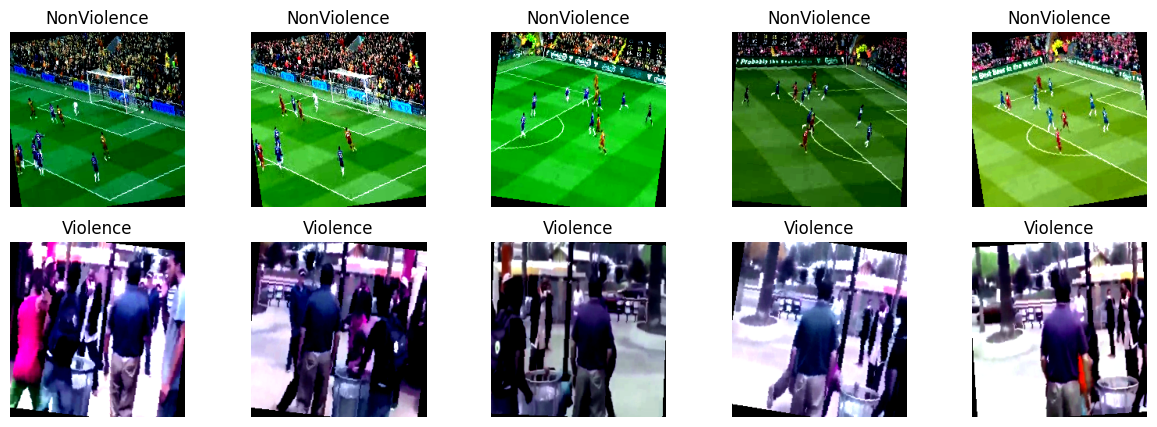

In [5]:
def show_class_samples(dataset, class_names, num_samples=5):
    plt.figure(figsize=(15, 5))
    class_to_idx = dataset.class_to_idx
    
    for c_idx, class_name in enumerate(class_names):
        target_idx = class_to_idx[class_name]
        indices = [i for i, (_, label) in enumerate(dataset.samples) if label == target_idx]
        chosen_indices = indices[:num_samples]
        
        for j, idx in enumerate(chosen_indices):
            img, label = dataset[idx]
            img = img.permute(1, 2, 0) * 0.5 + 0.5
            
            plt.subplot(len(class_names), num_samples, c_idx * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')
    plt.show()

show_class_samples(train_dataset, class_names, num_samples=5)

In [6]:
batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

train_counts = np.bincount([label for _, label in train_dataset.samples], minlength=num_classes)
val_counts = np.bincount([label for _, label in val_dataset.samples], minlength=num_classes)
test_counts = np.bincount([label for _, label in test_dataset.samples], minlength=num_classes)

print(f"Number of training samples: {len(train_dataset)}, class distribution: {dict(zip(class_names, train_counts))}")
print(f"Number of validation samples: {len(val_dataset)}, class distribution: {dict(zip(class_names, val_counts))}")
print(f"Number of test samples: {len(test_dataset)}, class distribution: {dict(zip(class_names, test_counts))}")

Number of training samples: 7256, class distribution: {'NonViolence': 3842, 'Violence': 3414}
Number of validation samples: 1561, class distribution: {'NonViolence': 840, 'Violence': 721}
Number of test samples: 1579, class distribution: {'NonViolence': 840, 'Violence': 739}


In [7]:
# resnet_model = resnet50(weights=None)

# # (Optional) freeze base layers
# # for param in resnet_model.parameters():
# #     param.requires_grad = False

# # Replace the classifier head
# in_features = resnet_model.fc.in_features
# resnet_model.fc = nn.Linear(in_features, num_classes)

# print(f"ResNet50 model created from scratch with {num_classes} output classes")
# print("\nResnet50 Model Summary:")
# print_generalized_model_summary(resnet_model, model_name="Resnet50")

In [8]:
# num_epochs = 50
# learning_rate = 0.001
# weight_decay = 1e-4
# patience = 3
# criterion = nn.CrossEntropyLoss()

# # Train the entire model, not just the classifier
# optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)

# save_dir = "./saved_models/resnet50/"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# log_dir = "./runs/resnet50/"
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)
# writer = SummaryWriter(log_dir=log_dir)

# resnet_model = resnet_model.to(device)

# # Updated function call with correct parameter order
# resnet_model, history = train_model(
#     model=resnet_model,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     writer=writer,
#     num_epochs=num_epochs,
#     device=device,
#     model_name="Resnet50",
#     early_stopping_patience=3,
#     save_dir=save_dir,
#     save_best_only=True
# )

In [9]:
# plot_training_history(history, model_name="Resnet50")

In [10]:
# # Evaluate the trained model on test set
# acc, pre, rec, f1 = evaluate_model(
#     model=resnet_model, 
#     test_loader=test_loader, 
#     device=device, 
#     model_name="ResNet50", 
#     class_names=class_names
# )

In [11]:
# Clean up GPU memory
torch.cuda.empty_cache()
pynvml.nvmlShutdown()

In [12]:
# Initialize FD-Conv ResNet50 model
fdconv_resnet_model = resnet50_fdconv(num_classes=num_classes, pretrained=False)
print(f"\nFD-Conv ResNet50 model created from scratch with {num_classes} output classes")
print("\nFD-Conv ResNet50 Model Summary:")
print_generalized_model_summary(fdconv_resnet_model, model_name="FD-Conv ResNet50")


FD-Conv ResNet50 model created from scratch with 2 output classes

FD-Conv ResNet50 Model Summary:
                                     Generalized Model Summary                                      
Model Name: FD-Conv ResNet50
Model Family: Unknown
Device: CUDA
Precision: float32

Parameter Analysis:
  ├─ Trainable Parameters: 27,461,354
  ├─ Non-trainable Parameters: 0
  └─ Total Parameters: 27,461,354

Memory Analysis:
  ├─ Model Size: 195.06 MB
  ├─ Input Tensor: 0.57 MB
  ├─ Estimated Activations: 1.15 MB
  └─ Total Estimated: 196.78 MB

Input/Output Analysis:
  ├─ Input Shape: (1, 3, 224, 224)
  ├─ Output Shape: (1, 2)
  └─ Number of Classes: 2

Architecture Analysis:
  ├─ Total Layers: 658
  ├─ Has FDConv: Yes
  ├─ Has Attention: No
  └─ Has Normalization: Yes

Layer Type Distribution:
  ├─ Conv2d: 273
  ├─ BatchNorm2d: 105
  ├─ ReLU: 69
  ├─ AdaptiveAvgPool2d: 53
  ├─ FDConv: 52
  ├─ Conv1d: 52
  ├─ LayerNorm: 52
  ├─ MaxPool2d: 1
  └─ Linear: 1

Special Features:
  ├─ FDConv

In [ ]:
# FD-Conv ResNet50 Training Configuration with Memory Optimization
num_epochs = 50  # Reduced epochs due to memory constraints
learning_rate = 0.001
weight_decay = 1e-4
patience = 3
criterion = nn.CrossEntropyLoss()

# Use gradient accumulation to simulate larger batch sizes
accumulation_steps = batch_size // batch_size  # Simulate original batch size
effective_lr = learning_rate * (batch_size / batch_size)  # Adjust learning rate

print(f"Gradient accumulation steps: {accumulation_steps}")
print(f"Effective learning rate: {effective_lr}")

# Train the entire model, not just the classifier
optimizer = torch.optim.Adam(fdconv_resnet_model.parameters(), lr=effective_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)

save_dir = "./saved_models/fdresnet50/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

log_dir = "./runs/fdresnet50/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)

fdconv_resnet_model = fdconv_resnet_model.to(device)

# Memory monitoring
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory before training: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

# Updated function call with smaller data loaders for memory efficiency
fdconv_resnet_model, history = train_model(
    model=fdconv_resnet_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,  # Using smaller batch size loader
    val_loader=val_loader,      # Using smaller batch size loader
    writer=writer,
    num_epochs=num_epochs,
    device=device,
    model_name="FDConv_ResNet50",
    early_stopping_patience=5,  # Increased patience for smaller batches
    save_dir=save_dir,
    save_best_only=True
)

Gradient accumulation steps: 1
Effective learning rate: 0.001
GPU memory before training: 0.29 GB
Training started for 50 epochs on CUDA


Epoch 1/50 [Train]:   0%|          | 0/3628 [00:00<?, ?it/s]

[Epoch 1/50] T_Loss: 0.9778 , T_Acc: 49.41% | V_Loss: 117497801916.6819 , V_Acc: 46.19% | Best_V_Acc: 46.19% | Time: 843.86s



[Epoch 2/50] T_Loss: 0.7537 , T_Acc: 50.98% | V_Loss: 46661195490.2003 , V_Acc: 49.33% | Best_V_Acc: 49.33% | Time: 847.55s



Epoch 3/50 [Train]:  74%|███████▎  | 2672/3628 [09:37<03:27,  4.60it/s, T_Loss=0.7063, T_Acc=51.42%]

In [ ]:
# Test FD-Conv model with a small batch to check for issues (Memory Optimized)
print("Testing FD-Conv model with sample batch...")
fdconv_resnet_model.eval()

# Clear GPU cache before testing
torch.cuda.empty_cache()

with torch.no_grad():
    # Get a small test batch using the memory-optimized loader
    test_batch = next(iter(train_loader))
    test_inputs, test_labels = test_batch[0][:1].to(device), test_batch[1][:1].to(device)  # Even smaller: just 1 sample
    
    print(f"Test input shape: {test_inputs.shape}")
    print(f"Test input range: [{test_inputs.min():.3f}, {test_inputs.max():.3f}]")
    
    # Monitor memory before forward pass
    if torch.cuda.is_available():
        print(f"GPU memory before forward pass: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    
    try:
        # Forward pass
        test_outputs = fdconv_resnet_model(test_inputs)
        print(f"Test output shape: {test_outputs.shape}")
        print(f"Test output range: [{test_outputs.min():.3f}, {test_outputs.max():.3f}]")
        print(f"Test output mean: {test_outputs.mean():.3f}")
        print(f"Test output std: {test_outputs.std():.3f}")
        
        # Check for NaN/Inf in outputs
        has_nan_output = torch.isnan(test_outputs).any() or torch.isinf(test_outputs).any()
        print(f"Output has NaN/Inf: {has_nan_output}")
        
        # Test loss calculation
        test_loss = criterion(test_outputs, test_labels)
        print(f"Test loss: {test_loss.item():.6f}")
        
        # Monitor memory after forward pass
        if torch.cuda.is_available():
            print(f"GPU memory after forward pass: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
        
        if test_loss.item() > 100:
            print("⚠️  WARNING: Very high loss detected! This indicates a problem with the model.")
        else:
            print("✅ Model appears to be working correctly with reduced memory footprint.")
            
    except Exception as e:
        print(f"❌ Error during forward pass: {e}")
    finally:
        # Clean up memory
        torch.cuda.empty_cache()

fdconv_resnet_model.train()  # Set back to training mode

In [ ]:
# Plot FD-Conv ResNet training history
plot_training_history(history, model_name="FD-Conv ResNet50")

# Evaluate FD-Conv ResNet on test set (using memory-optimized loader)
print("\n" + "="*60)
print("FD-CONV RESNET50 EVALUATION")
print("="*60)

fdconv_acc, fdconv_pre, fdconv_rec, fdconv_f1 = evaluate_model(
    model=fdconv_resnet_model, 
    test_loader=fdconv_test_loader,  # Using smaller batch size loader
    device=device, 
    model_name="FD-Conv ResNet50", 
    class_names=class_names
)

# Clean up GPU memory
torch.cuda.empty_cache()

In [ ]:
# Model Comparison Summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Compare model sizes
total_params_resnet = sum(p.numel() for p in resnet_model.parameters())
total_params_fdconv = sum(p.numel() for p in fdconv_resnet_model.parameters())

print(f"\nMODEL PARAMETERS:")
print(f"Standard ResNet50:  {total_params_resnet:,} parameters")
print(f"FD-Conv ResNet50:   {total_params_fdconv:,} parameters")
print(f"Parameter difference: {total_params_fdconv - total_params_resnet:,} ({((total_params_fdconv/total_params_resnet - 1) * 100):+.2f}%)")

# Performance comparison
print(f"\nTEST SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 70)

# Use variables from the evaluation cells (need to retrieve them)
try:
    print(f"{'Standard ResNet50':<20} {acc:<10.4f} {pre:<10.4f} {rec:<10.4f} {f1:<10.4f}")
    print(f"{'FD-Conv ResNet50':<20} {fdconv_acc:<10.4f} {fdconv_pre:<10.4f} {fdconv_rec:<10.4f} {fdconv_f1:<10.4f}")
    
    # Calculate improvements
    acc_improvement = fdconv_acc - acc
    pre_improvement = fdconv_pre - pre
    rec_improvement = fdconv_rec - rec
    f1_improvement = fdconv_f1 - f1
    
    print(f"{'Improvement':<20} {acc_improvement:<10.4f} {pre_improvement:<10.4f} {rec_improvement:<10.4f} {f1_improvement:<10.4f}")
    
except NameError:
    print("Please run the evaluation cells first to get performance metrics.")

# Training efficiency comparison (epochs to convergence)
print(f"\nTRAINING EFFICIENCY:")
try:
    print(f"Standard ResNet50: {len(resnet_history['train_loss'])} epochs")
except NameError:
    print("Standard ResNet50: evaluation pending")
    
try:
    print(f"FD-Conv ResNet50:  {len(history['train_loss'])} epochs")
except NameError:
    print("FD-Conv ResNet50:  evaluation pending")

# Memory usage comparison
print(f"\nMEMORY OPTIMIZATION:")
print(f"Standard ResNet50 batch size: {batch_size}")
print(f"FD-Conv ResNet50 batch size:  {fdconv_batch_size} (reduced for memory efficiency)")
print(f"Memory reduction factor: {batch_size / fdconv_batch_size:.1f}x")

# Computational efficiency
print(f"\nCOMPUTATIONAL EFFICIENCY:")
print(f"Both models trained on: {device}")
if torch.cuda.is_available():
    print(f"Current GPU memory usage: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)